In [1]:
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared
plt.style.use('default')
#plt.style.use('bmh')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:

np.random.seed(629)

#%%
testData = pd.read_csv("outGroupF3_Region_pairwise_allEnv_noCol0_euclidean_dist.txt", sep='\t',)#

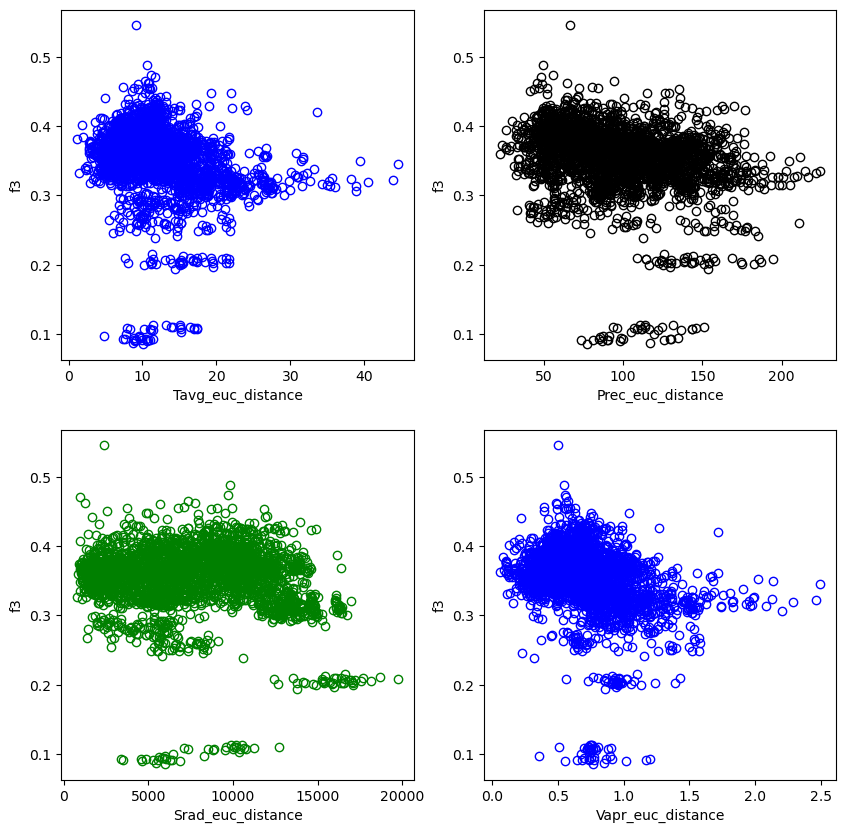

In [3]:
fid,ax = plt.subplots(2,2, figsize = (10,10),)

ax[0,0].scatter(testData['t'], testData['f3'],lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0,0].set_xlabel('Tavg_euc_distance')
ax[0,0].set_ylabel('f3')
ax[0,1].scatter(x =testData['p'], y=testData['f3'],lw=1, color=(0, 0, 0, 0), edgecolor="k")
ax[0,1].set_xlabel('Prec_euc_distance')
ax[0,1].set_ylabel('f3')
ax[1,0].scatter(x =testData['s'], y=testData['f3'],lw=1, color=(0, 0, 0, 0), edgecolor="g")
ax[1,0].set_xlabel('Srad_euc_distance')
ax[1,0].set_ylabel('f3')
#ax[3].scatter(x =testData['vapr'], y=testData['allChrChunkMean'],lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1,1].scatter(x =testData['v'], y=testData['f3'],lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1,1].set_xlabel('Vapr_euc_distance')
ax[1,1].set_ylabel('f3')
plt.savefig('envVariablesXOutgroupF3.png', format = 'png',)

In [4]:
#%%
def standardize(series):
    "standardize pandas series"
    std_series = (series - series.mean())/series.std()
    return std_series
# %%
testData['tavg_std'] = standardize(testData['t'])
testData['prec_std'] = standardize(testData['p'])
testData['srad_std'] = standardize(testData['s'])
testData['vapr_std'] = standardize(testData['v'])
testData['wind_std'] = standardize(testData['w'])
testData['f3_std'] = standardize(testData['f3'])

In [5]:
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action="ignore", category=FutureWarning)
labelencoder = LabelEncoder()
testData['groupIDs']= labelencoder.fit_transform(testData['newGroup'])
testData['clusterIDs']= labelencoder.fit_transform(testData['region'])

group_names = testData.newGroup.unique()
group_idx = testData.groupIDs.values
cluster_idx = testData.clusterIDs.values
n_group = len(group_names)

In [6]:
#testData[testData['groupIDs']==6]

In [7]:
with pm.Model() as m_hier:
    #hyperpriors
    a_bar = pm.Normal('a_bar', 0,1)
    sigma = pm.Exponential('sigma',1)
    bt_bar=pm.Normal('bt_bar', 0,1)
    bp_bar=pm.Normal('bp_bar', 0,1)
    bs_bar=pm.Normal('bs_bar', 0,1)
    #bw_bar=pm.Normal('bw_bar', 0,1)
    bv_bar=pm.Normal('bv_bar', 0,1)
    nu= pm.Gamma('nu',alpha=2, beta =0.1)

    #priors
    a = pm.Normal('alpha', mu = a_bar, sigma =sigma, shape = n_group)
    bP = pm.Normal('bP', mu = bp_bar, sigma=sigma, shape =n_group)
    bT = pm.Normal('bT', mu = bt_bar, sigma=sigma, shape =n_group)
    bS = pm.Normal('bS', mu = bs_bar, sigma=sigma, shape =n_group)
    bV = pm.Normal('bV', mu = bv_bar, sigma = sigma, shape = n_group)


    #expected
    f3_est = a[group_idx] + bP[group_idx]*testData.prec_std.values + bT[group_idx]*testData.tavg_std.values+ bS[group_idx]*testData.srad_std.values+bV[group_idx]*testData.vapr_std.values

    #likelihood
    f3_like = pm.StudentT('f3_like', nu=nu, mu = f3_est, sigma =sigma, observed = testData.f3_std)
    
    #trace
    m_hier_trace = pm.sample(draws=4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bV, bS, bT, bP, alpha, nu, bv_bar, bs_bar, bp_bar, bt_bar, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 51 seconds.


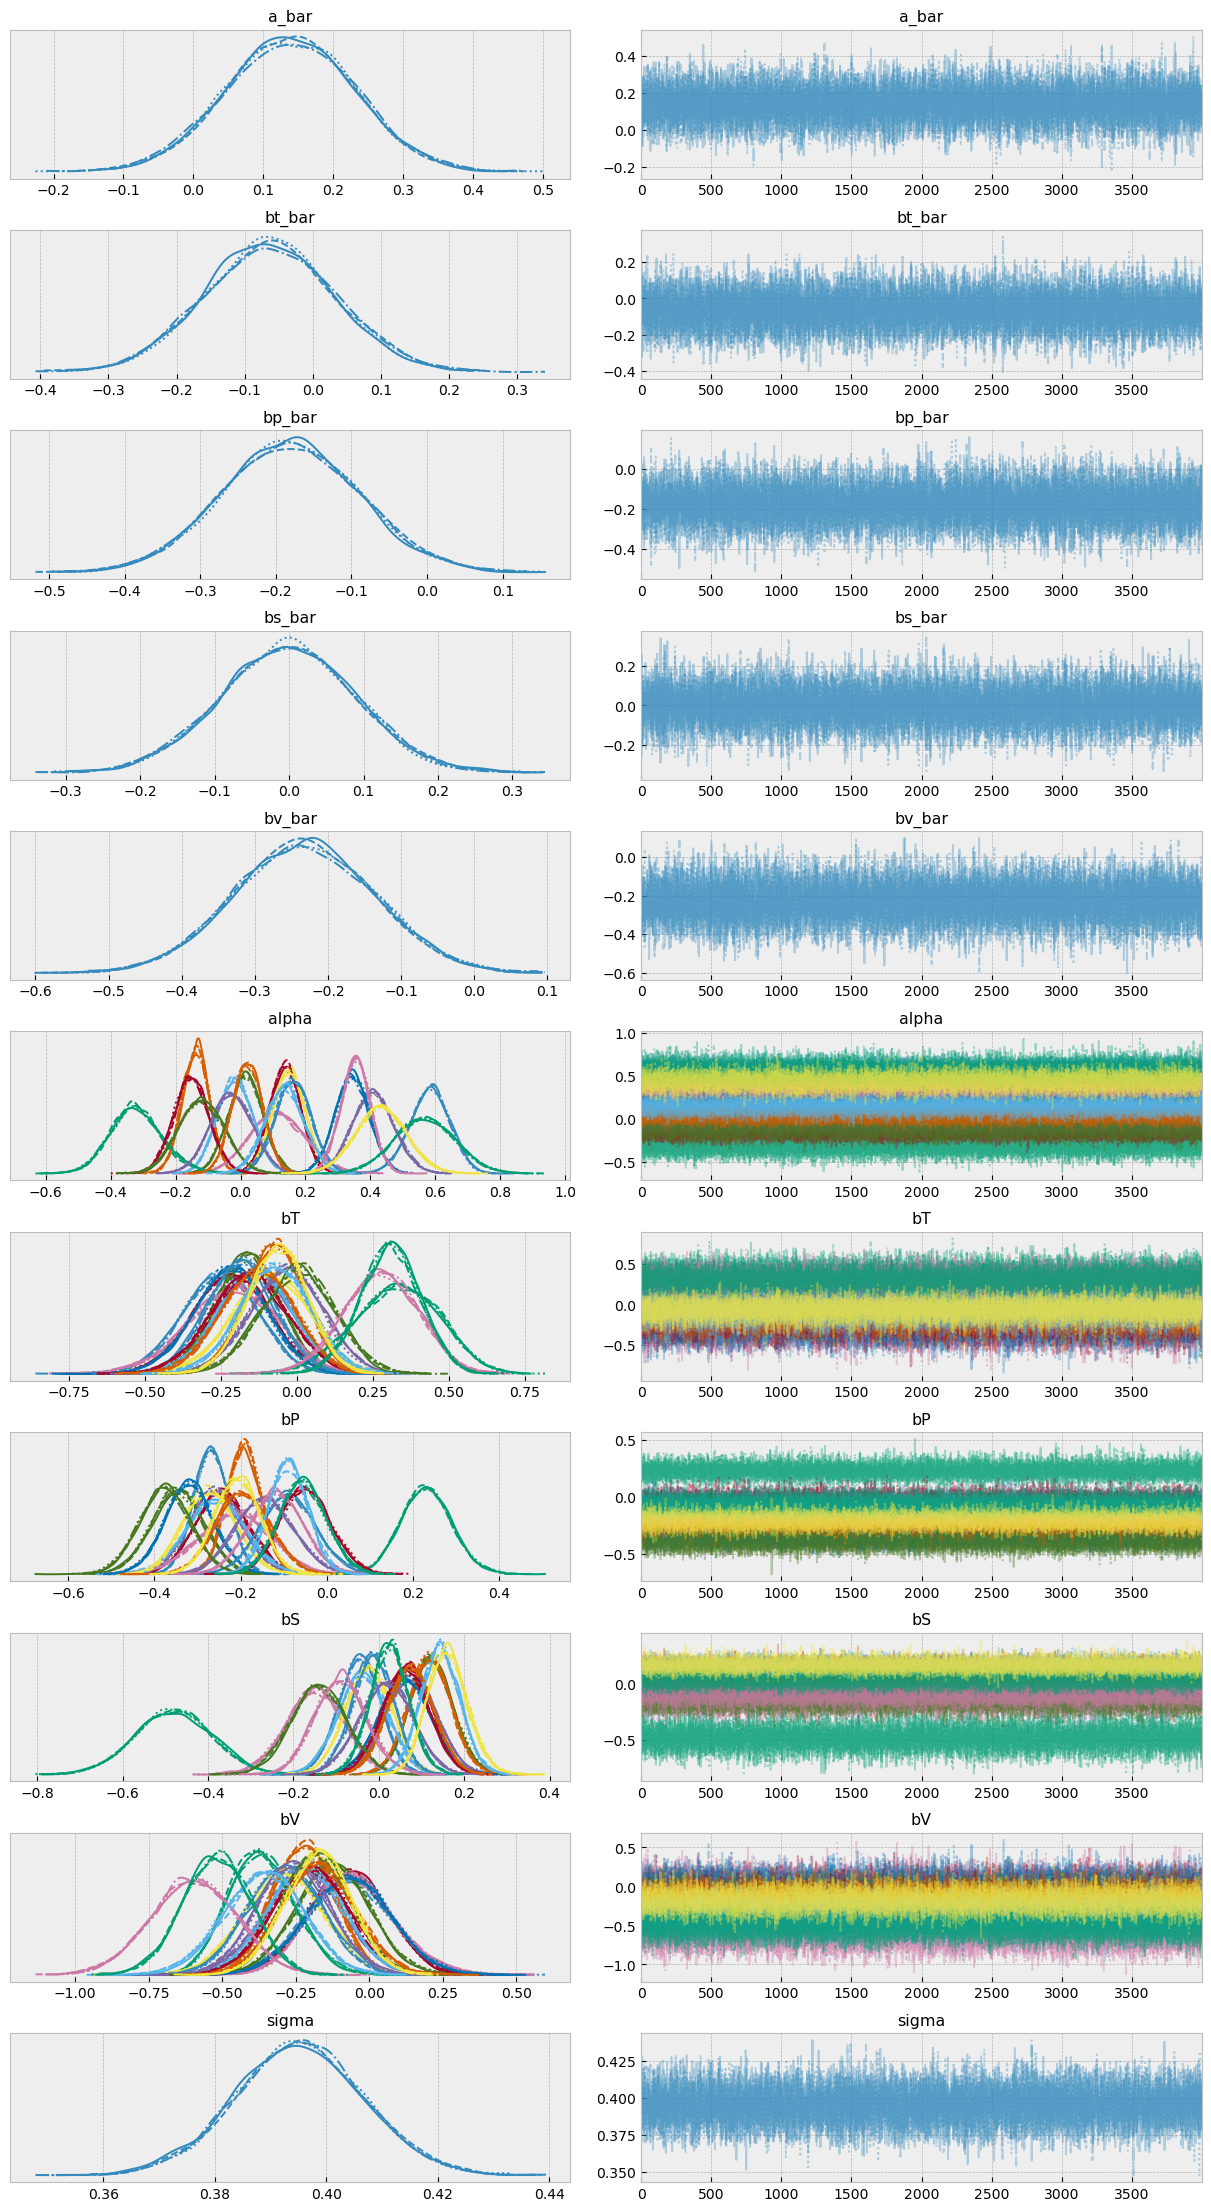

In [8]:
plt.style.use('bmh')
pm.traceplot(m_hier_trace,
#var_names = ['a_bar','bt_bar','bp_bar','bs_bar','alpha', 'bT','bP','bS', 'sigma'],);
var_names = ['a_bar','bt_bar','bp_bar','bs_bar','bv_bar','alpha', 'bT','bP','bS','bV', 'sigma'],);
plt.savefig('outGroupF3_hierarchical_traceplot_noCol0.png', dpi=300);

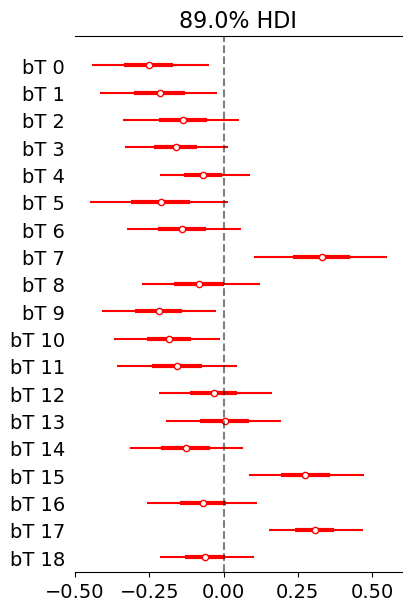

In [9]:
plt.style.use('default')
az.plot_forest(m_hier_trace, var_names=['bT',],combined=True,figsize=(4,6),hdi_prob=0.89, colors='red')
plt.axvline(x=0,ls='--',color='k',alpha=0.5);
plt.savefig("outgroupF3_bT_groupwise.pdf")

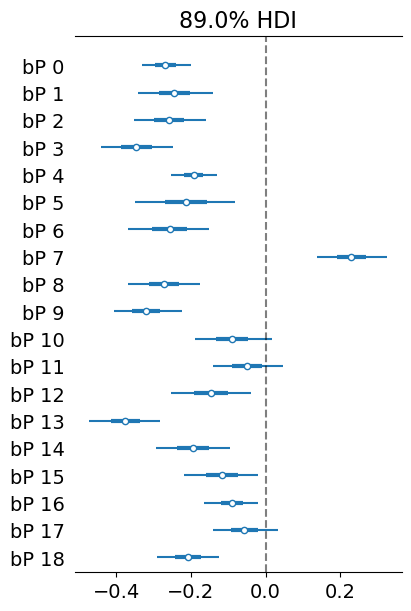

In [145]:
az.plot_forest(m_hier_trace, var_names=['bP'],combined=True,figsize=(4,6), hdi_prob = 0.89)
plt.axvline(x=0,ls='--',color='k',alpha=0.5);
plt.savefig("outGroupF3_bP_groupwise.pdf")

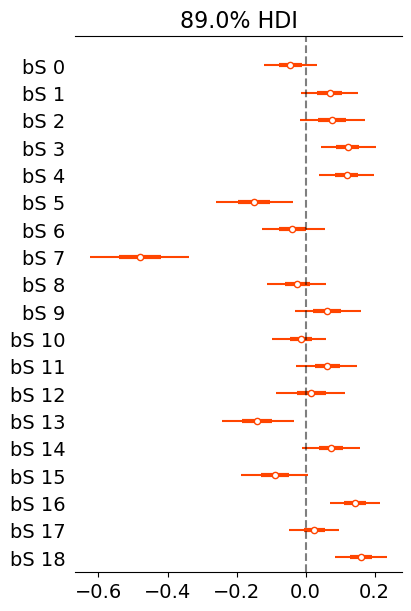

In [146]:
az.plot_forest(m_hier_trace, var_names=['bS'],combined=True,figsize=(4,6), hdi_prob = 0.89, colors = "#FF4500")
plt.axvline(x=0,ls='--',color='k',alpha=0.5);
plt.savefig("outGroupF3_bS_groupwise.pdf")

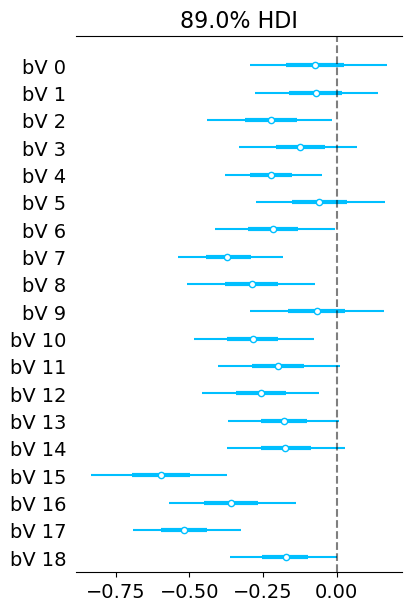

In [147]:
az.plot_forest(m_hier_trace, var_names=['bV'],combined=True,figsize=(4,6), hdi_prob = 0.89, colors = "#00BFFF")
plt.axvline(x=0,ls='--',color='k',alpha=0.5);
plt.savefig("outGroupF3_bV_groupwise.pdf")

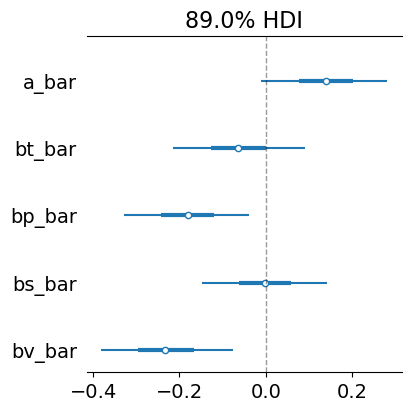

In [148]:
# %%
az.plot_forest(m_hier_trace, var_names=['a_bar','bt_bar','bp_bar','bs_bar','bv_bar'],colors ='cycle',combined=True,figsize=(4,4), hdi_prob=0.89,
               kind='forestplot',ridgeplot_alpha=0.2,);
plt.axvline(x=0,color='k', ls='--',lw=1.,alpha=0.4)
plt.savefig('outGroupF3_posteriorParameters.pdf')

In [149]:
a = pm.summary(m_hier_trace)
a.to_csv("hierSummaryEuclidean_F3StudentT_Dist.txt.gz", sep='\t', float_format="%.4f")
group_index_info = testData[['newGroup', 'groupIDs']]
group_index_info.to_csv("outGroupF3_group_index_info.txt.gz", sep ="\t",index = False)

### reference : https://docs.pymc.io/notebooks/GLM-hierarchical.html

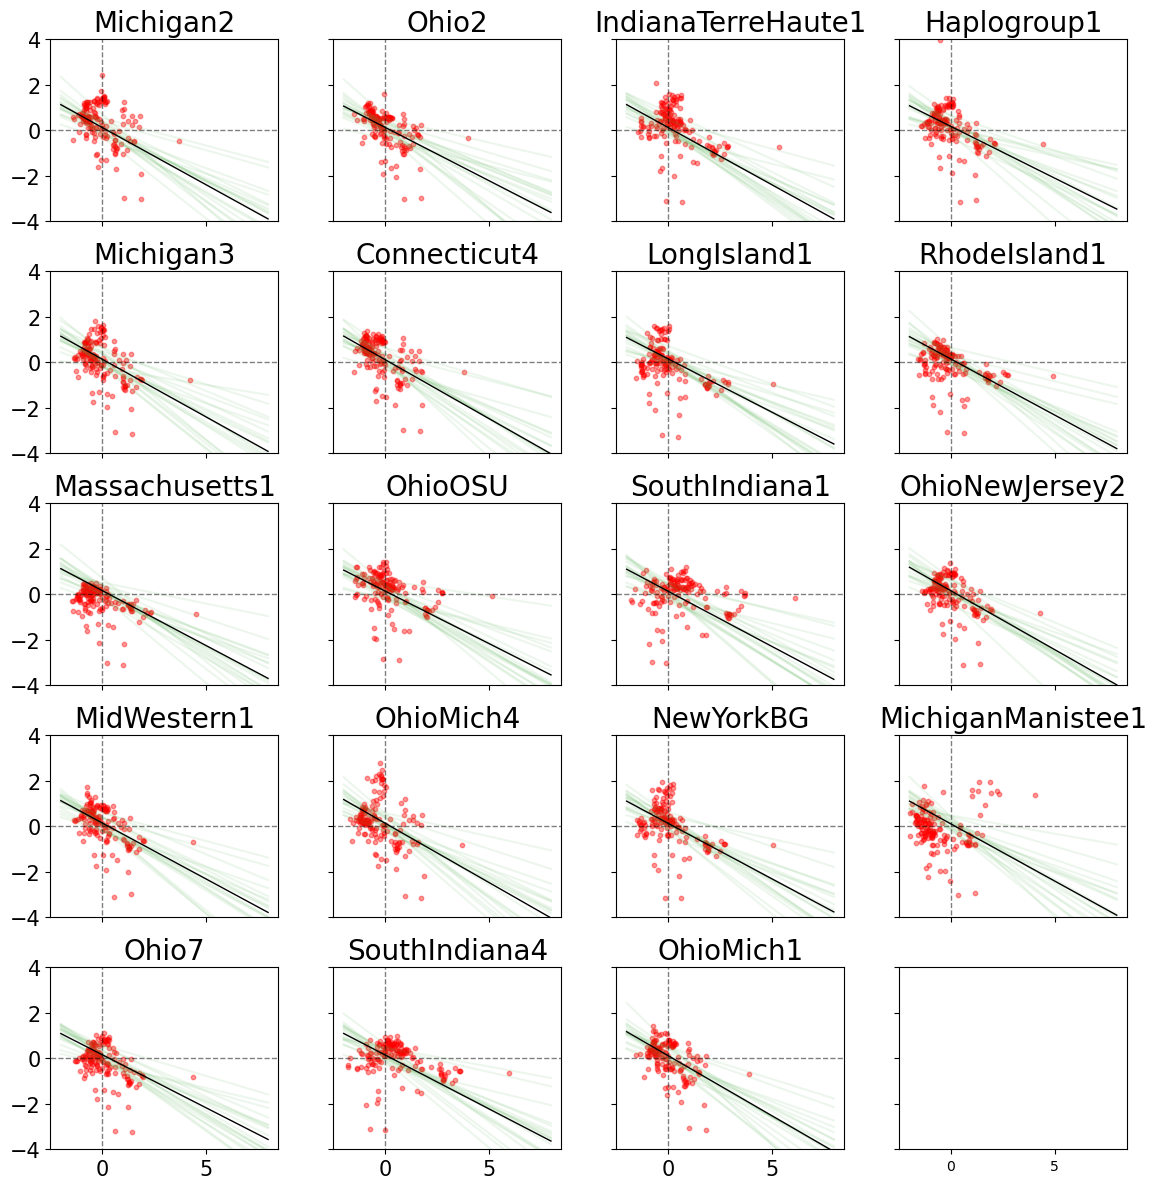

In [17]:
# %%
##tavg

fig, axis = plt.subplots(5,4, figsize=(12,12), sharey=True, sharex=True)
axis =axis.ravel()
for i, c in enumerate(group_names):
    c_data = testData[testData.newGroup == c]
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(group_names==c)[0][0]
    z = list(c_data['groupIDs'])[0]
    
    xvals=np.linspace(-2,8,2)
    
    for a_val, bT_val, bP_val,bS_val,bV_val in zip(m_hier_trace['alpha'][z], m_hier_trace['bT'][z], m_hier_trace['bP'][z],m_hier_trace['bS'][z],m_hier_trace['bV'][z]):
        axis[i].plot(xvals, a_val+bT_val*xvals+bP_val*xvals+bS_val*xvals+bV_val*xvals, '#4daf4a', alpha=0.1)
    axis[i].plot(xvals, m_hier_trace['alpha'][z].mean()+ m_hier_trace['bT'][z].mean()*xvals + m_hier_trace['bP'][z].mean()*xvals+m_hier_trace['bS'][z].mean()*xvals+m_hier_trace['bV'][z].mean()*xvals,
                'k', alpha=1, lw=1, label='hierarchical')
    axis[i].scatter(c_data.tavg_std + np.random.randn(len(c_data))*0.01, c_data.f3_std,
                   alpha =0.4, color = 'r', marker = '.', s =40, label = 'original data')
    
    axis[i].tick_params(axis='both',labelsize=15)
    axis[i].set_ylim(-4, 4)
    axis[i].set_title(c,fontsize= 20)
    #axis[i].set_ylabel('ChunkMean_standardized')
    #axis[i].set_xlabel('tavg_standardized')
    axis[i].axvline(x=0,ymin=-1,ymax=3,color='k',ls='--',lw=1.,alpha=0.5 )
    axis[i].axhline(y=0,xmin=-2,xmax=8,color='k',ls='--',lw=1.,alpha=0.5 )
    #
plt.tight_layout()
plt.savefig('outgroupF3_ppc_tavg_std.pdf')

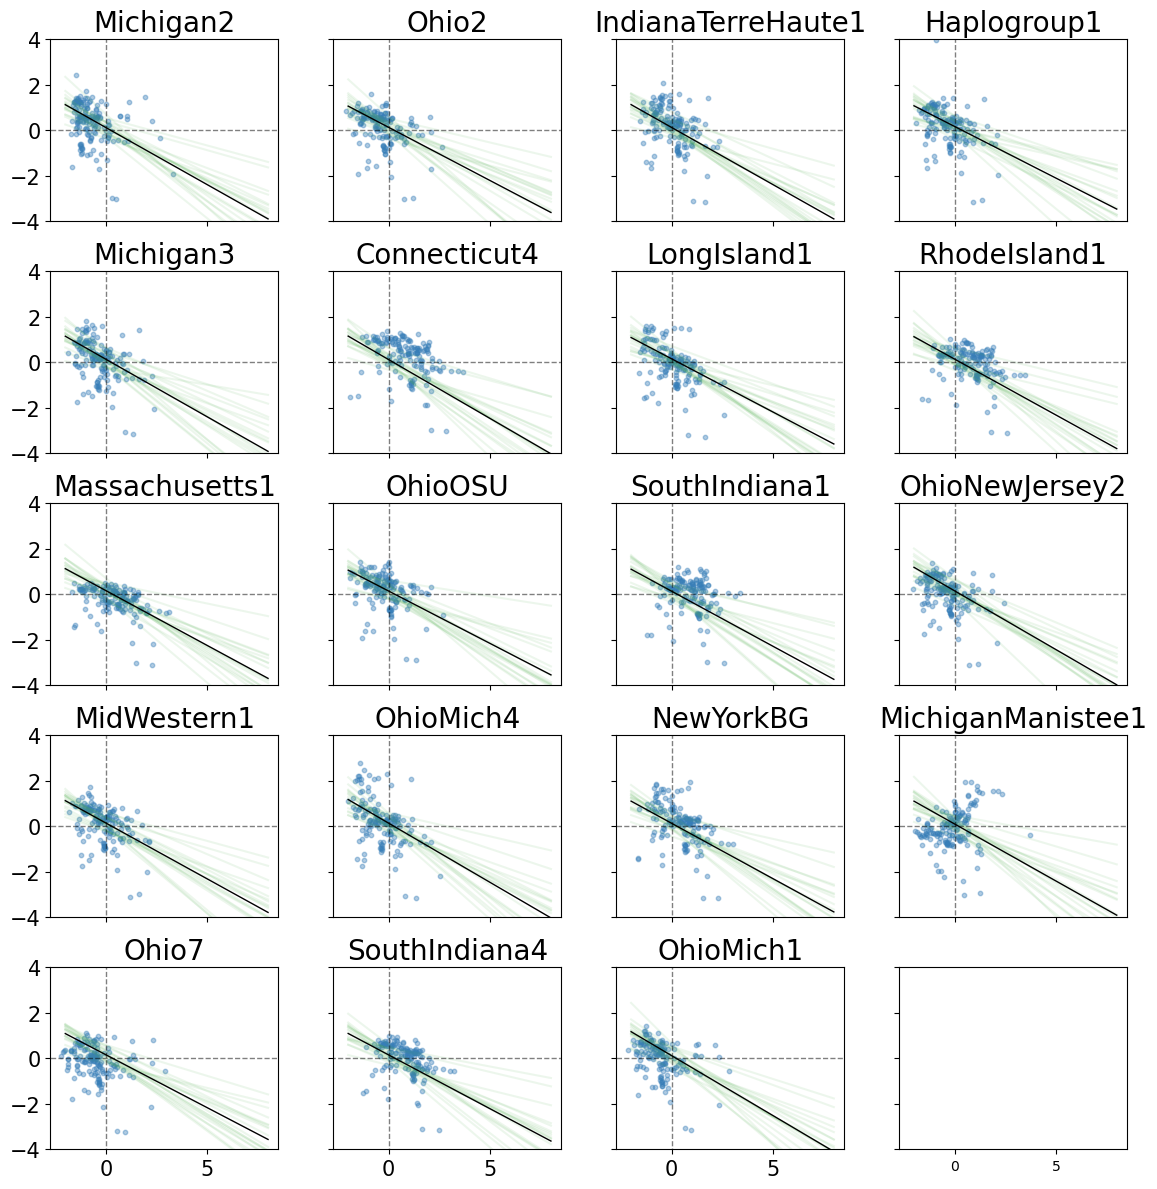

In [18]:
# %%
##prec

fig, axis = plt.subplots(5,4, figsize=(12,12), sharey=True, sharex=True)
axis =axis.ravel()
for i, c in enumerate(group_names):
    c_data = testData[testData.newGroup == c]
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(group_names==c)[0][0]
    z = list(c_data['groupIDs'])[0]
    
    xvals=np.linspace(-2,8,2)
    
    for a_val, bT_val, bP_val,bS_val,bV_val in zip(m_hier_trace['alpha'][z], m_hier_trace['bT'][z], m_hier_trace['bP'][z],m_hier_trace['bS'][z],m_hier_trace['bV'][z]):
        axis[i].plot(xvals, a_val+bT_val*xvals+bP_val*xvals+bS_val*xvals+bV_val*xvals, '#4daf4a', alpha=0.1)
    axis[i].plot(xvals, m_hier_trace['alpha'][z].mean()+ m_hier_trace['bT'][z].mean()*xvals + m_hier_trace['bP'][z].mean()*xvals+m_hier_trace['bS'][z].mean()*xvals+m_hier_trace['bV'][z].mean()*xvals,
                'k', alpha=1, lw=1, label='hierarchical')
    axis[i].scatter(c_data.prec_std + np.random.randn(len(c_data))*0.01, c_data.f3_std,
                   alpha =0.4, color = '#377eb8', marker = '.', s =40, label = 'original data')
    axis[i].tick_params(axis='both',labelsize=15)
    axis[i].set_ylim(-4, 4)
    axis[i].set_title(c,fontsize= 20)
    #axis[i].set_ylabel('ChunkMean_standardized')
    #axis[i].set_xlabel('tavg_standardized')
    axis[i].axvline(x=0,ymin=-1,ymax=3,color='k',ls='--',lw=1.,alpha=0.5 )
    axis[i].axhline(y=0,xmin=-2,xmax=8,color='k',ls='--',lw=1.,alpha=0.5 )
plt.tight_layout()
plt.savefig('outgroupF3_ppc_prec_std.pdf')

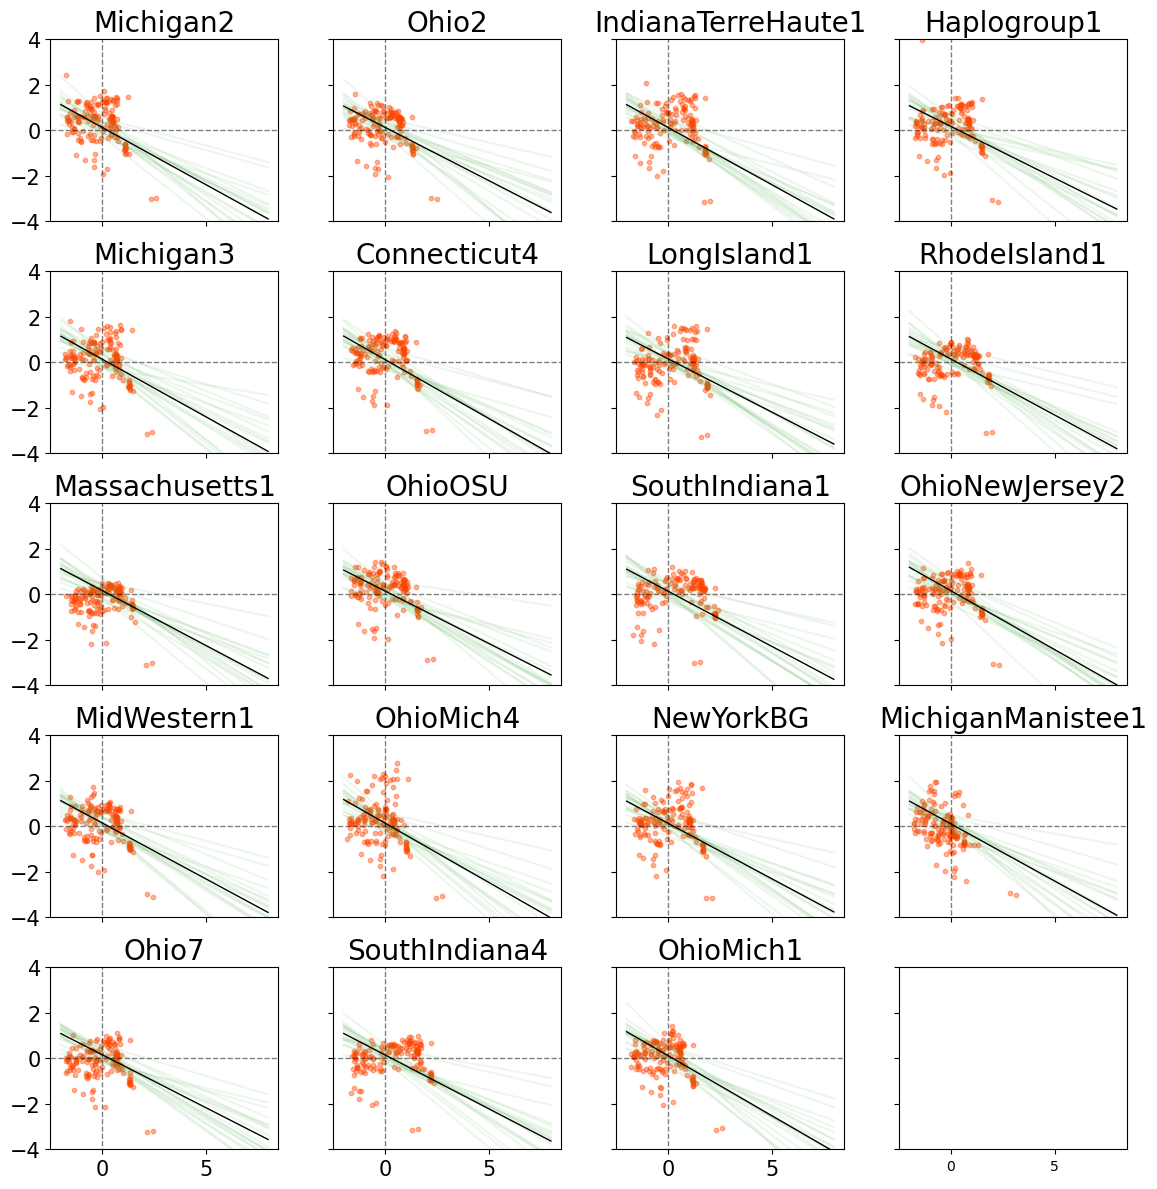

In [19]:
# %%
##srad

fig, axis = plt.subplots(5,4, figsize=(12,12), sharey=True, sharex=True)
axis =axis.ravel()
for i, c in enumerate(group_names):
    c_data = testData[testData.newGroup == c]
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(group_names==c)[0][0]
    z = list(c_data['groupIDs'])[0]
    
    xvals=np.linspace(-2,8,2)
    
    for a_val, bT_val, bP_val,bS_val,bV_val in zip(m_hier_trace['alpha'][z], m_hier_trace['bT'][z], m_hier_trace['bP'][z],m_hier_trace['bS'][z],m_hier_trace['bV'][z]):
        axis[i].plot(xvals, a_val+bT_val*xvals+bP_val*xvals+bS_val*xvals+bV_val*xvals, '#4daf4a', alpha=0.1)
    axis[i].plot(xvals, m_hier_trace['alpha'][z].mean()+ m_hier_trace['bT'][z].mean()*xvals + m_hier_trace['bP'][z].mean()*xvals+m_hier_trace['bS'][z].mean()*xvals+m_hier_trace['bV'][z].mean()*xvals,
                'k', alpha=1, lw=1, label='hierarchical')
    axis[i].scatter(c_data.srad_std + np.random.randn(len(c_data))*0.01, c_data.f3_std,
                   alpha =0.4, color = '#FF4500', marker = '.', s =40, label = 'original data')
    axis[i].tick_params(axis='both',labelsize=15)
    axis[i].set_ylim(-4,4)
    axis[i].set_title(c,fontsize= 20)
    #axis[i].set_ylabel('ChunkMean_standardized')
    #axis[i].set_xlabel('tavg_standardized')
    axis[i].axvline(x=0,ymin=-1,ymax=3,color='k',ls='--',lw=1.,alpha=0.5 )
    axis[i].axhline(y=0,xmin=-2,xmax=8,color='k',ls='--',lw=1.,alpha=0.5 )
plt.tight_layout()
plt.savefig('outgroupF3_ppc_srad_std.pdf')

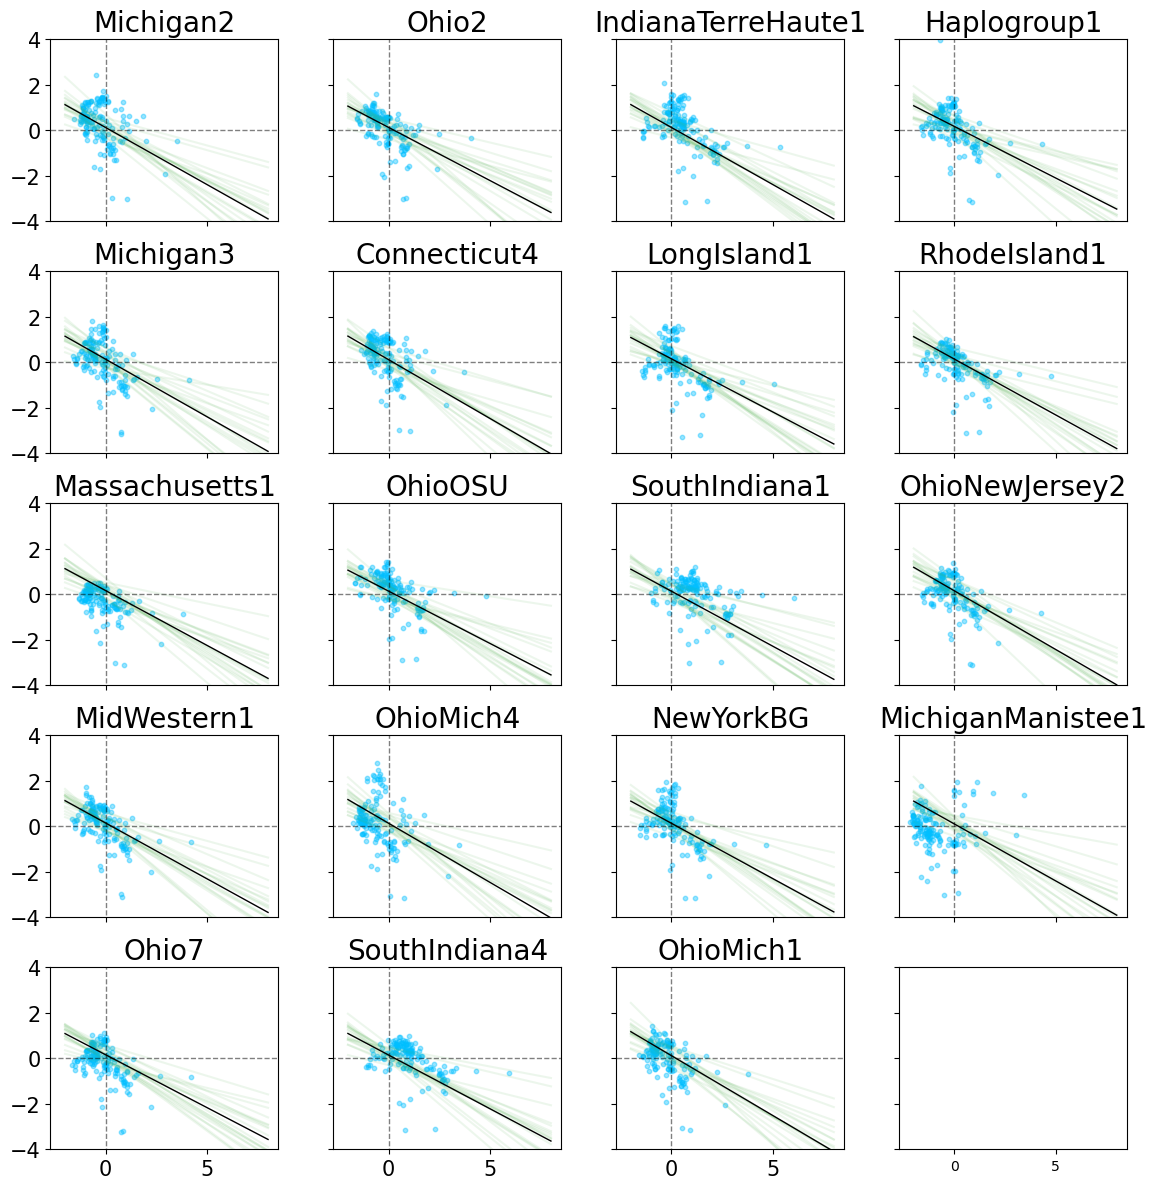

In [20]:
# %%
##vapr

fig, axis = plt.subplots(5,4, figsize=(12,12), sharey=True, sharex=True)
axis =axis.ravel()
for i, c in enumerate(group_names):
    c_data = testData[testData.newGroup == c]
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(group_names==c)[0][0]
    z = list(c_data['groupIDs'])[0]
    
    xvals=np.linspace(-2,8,2)
    
    for a_val, bT_val, bP_val,bS_val,bV_val in zip(m_hier_trace['alpha'][z], m_hier_trace['bT'][z], m_hier_trace['bP'][z],m_hier_trace['bS'][z],m_hier_trace['bV'][z]):
        axis[i].plot(xvals, a_val+bT_val*xvals+bP_val*xvals+bS_val*xvals+bV_val*xvals, '#4daf4a', alpha=0.1)
    axis[i].plot(xvals, m_hier_trace['alpha'][z].mean()+ m_hier_trace['bT'][z].mean()*xvals + m_hier_trace['bP'][z].mean()*xvals+m_hier_trace['bS'][z].mean()*xvals+m_hier_trace['bV'][z].mean()*xvals,
                'k', alpha=1, lw=1, label='hierarchical')
    axis[i].scatter(c_data.vapr_std + np.random.randn(len(c_data))*0.01, c_data.f3_std,
                   alpha =0.4, color = '#00BFFF', marker = '.', s =40, label = 'original data')
    axis[i].tick_params(axis='both',labelsize=15)
    axis[i].set_ylim(-4,4)
    axis[i].set_title(c,fontsize= 20)
    #axis[i].set_ylabel('ChunkMean_standardized')
    #axis[i].set_xlabel('tavg_standardized')
    axis[i].axvline(x=0,ymin=-1,ymax=3,color='k',ls='--',lw=1.,alpha=0.5 )
    axis[i].axhline(y=0,xmin=-2,xmax=8,color='k',ls='--',lw=1.,alpha=0.5 )
plt.tight_layout()
plt.savefig('outgroupF3_ppc_vapr_std.pdf')

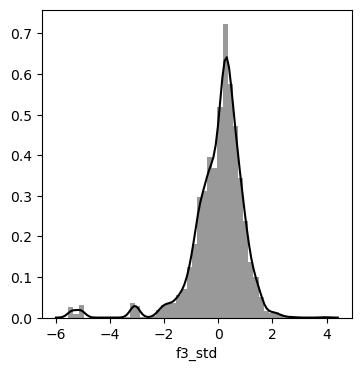

In [154]:
plt.figure(figsize=(4,4))
sns.distplot(testData.f3_std,color='k')
plt.savefig("f3_std_distplot.png",)

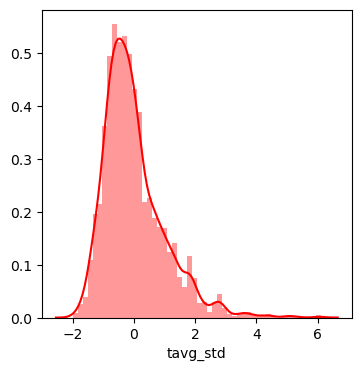

In [155]:
plt.figure(figsize=(4,4))
sns.distplot(testData.tavg_std,color='r')
plt.savefig("tavg_std_distplot.png",)

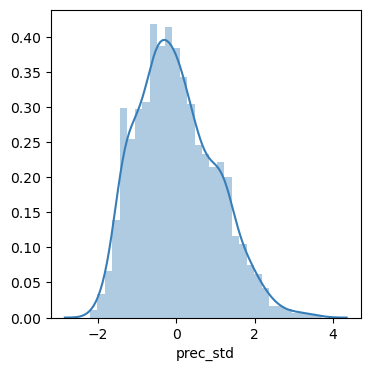

In [156]:
plt.figure(figsize=(4,4))
sns.distplot(testData.prec_std,color='#377eb8')
plt.savefig("prec_std_distplot.png",)

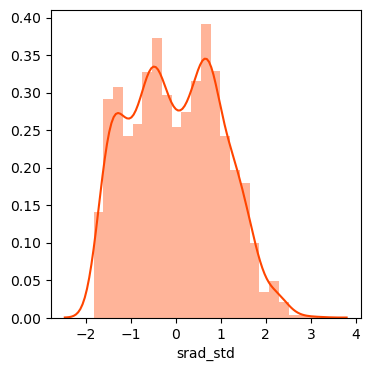

In [157]:
plt.figure(figsize=(4,4))
sns.distplot(testData.srad_std,color='#FF4500')
plt.savefig("srad_std_distplot.png",)

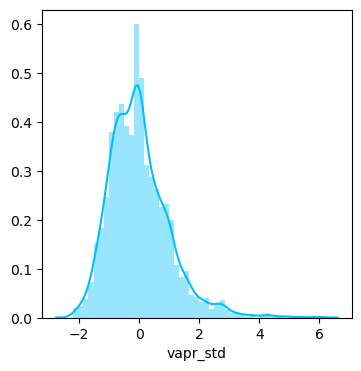

In [158]:
plt.figure(figsize=(4,4))
sns.distplot(testData.vapr_std,color='#00BFFF')
plt.savefig("vapr_std_distplot.png",)

In [164]:
#####Versions of libraries used########
%reload_ext watermark
%watermark -n -u -v -iv -w

pandas  1.1.1
daft    0.1.0
pymc3   3.9.3
numpy   1.19.1
arviz   0.9.0
seaborn 0.10.1
last updated: Wed Oct 21 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
